In [1]:
import tensorflow as tf
import cv2 
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from tensorflow.contrib.layers import layers
import glob
import os
os.chdir("../")

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [187]:
def showImg(self,img):
    plt.imshow(img,cmap=cm.gray)
    plt.show()

class dataGenerator():
    def __init__(self,cvSplit=0.8,batchSize=5,inputDim=(128,128),outputDim=(32,32)):
        rng.seed(1006)
        self.trainPaths, self.testPaths = [glob.glob(s+"/*[0-9].tif") for s in ["train","test"]]
        self.batchSize = batchSize
        self.inputDim = inputDim
        self.outputDim = outputDim
        print("%d train paths and %d test paths" % (len(self.trainPaths),len(self.testPaths)))
        
        # Split train into CV and non CV (cross validation)
        rng.shuffle(self.trainPaths)
        cvSplitPoint = int(cvSplit*len(self.trainPaths))
        self.trainPathsCV, self.testPathsCV = self.trainPaths[:cvSplitPoint], self.trainPaths[cvSplitPoint:]
        assert len(set(self.trainPathsCV).intersection(set(self.testPathsCV))) == 0 
        
        print("Train set split into %d train CV paths and %d test CV paths" % (len(self.trainPathsCV),len(self.testPathsCV)))     


    def loadImg(self,path,CV,augment=0,method=cv2.INTER_CUBIC):
        img = cv2.imread(path,0)
        maskPath = path.replace(".tif","_mask.tif")
        if os.path.exists(path = maskPath):
            mask = cv2.imread(maskPath,0)
        
        if augment == 1 and CV == 1:
            rows,cols = img.shape
            
            M = cv2.getRotationMatrix2D((cols/2,rows/2),np.random.uniform(-5,5),1)
            tX, tY = np.random.randint(0,10,2)
            M[0,2] = tX
            M[1,2] = tY
            img,mask = [im[5:rows-5, 5:cols-5] for im in [img,mask]]
            img,mask = [cv2.warpAffine(im,M,(cols,rows),borderMode = 1) for im in [img,mask]]
            
            img = cv2.resize(img,self.inputDim, interpolation = method)
            mask = cv2.resize(mask,self.outputDim, interpolation = method)
            return img,mask
        elif augment == 0 and CV == 1:
            img = cv2.resize(img,self.inputDim, interpolation = method)
            mask = cv2.resize(mask,self.outputDim, interpolation = method)
            return img,mask
        elif train == 0:
            img = cv2.resize(img,self.inputDim, interpolation = method)
            return img, _
        
    def gen(self,train):
        if train==1:
            paths = self.trainPathsCV
            rng.shuffle(paths)
            nObs = len(paths)
            augment = 1
            print("Augmenting")
            print("Training paths length =  %d" % nObs)
        elif train == 0:
            paths = self.testPathsCV
            rng.shuffle(paths)
            nObs = len(paths)
            augment = 0
            print("Not augmenting")
            print("Testing paths length =  %d" % nObs)
        self.idx = 0
        finished = 0
        while True:
            batchX = np.empty((self.batchSize,self.inputDim[0],self.inputDim[1],1))
            batchY = np.empty((self.batchSize,self.outputDim[0],self.outputDim[1],1))
            idx = 0
            for i in range(self.idx,min(self.batchSize+self.idx,nObs)):
                x,y = self.loadImg(paths[i],CV=1,augment=augment)
                x=x/255.0
                y=y/255.0
                x.resize(self.inputDim[0],self.inputDim[1],1), y.resize(self.outputDim[0],self.outputDim[1],1)
                batchX[idx],batchY[idx] = x, y
                idx += 1
            self.idx += self.batchSize
            if self.idx >= nObs:
                self.idx = 0
                finished = 1
            yield batchX,batchY, finished 

        

In [188]:
def weights(shape):
    initial = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(initial)

def bias(shape):
    initial = tf.constant(0.1,shape=shape)
    return tf.Variable(initial)

def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding="SAME")

def mp2(x):
    return tf.nn.max_pool(x,ksize = [1,2,2,1],strides=[1,2,2,1],padding="SAME")

In [239]:
with tf.variable_scope("deCnn"):
    inputDim, outputDim = (128,128), (8,8)
    x = tf.placeholder(tf.float32,shape=[None,inputDim[0],inputDim[0],1])
    y_ = tf.placeholder(tf.float32,shape=[None,outputDim[0],outputDim[0],1])

    convolutionLayers = []
    nConvolutions = 5
    nFeatsOut = 16
    nFeatsInc = 8
    for i in xrange(nConvolutions):
        if i ==0:
            nFeatsIn = 1
        elif i < nConvolutions - 1:
            nFeatsOut += nFeatsInc
        elif i == nConvolutions-1:
            nFeatsOut = 1

        W = weights([3,3,nFeatsIn,nFeatsOut])
        b = bias([nFeatsOut])
        convolutionLayers.append([W,b]) 
        nFeatsIn = nFeatsOut
        
    h1 = conv2d(x,convolutionLayers[0][0]) + convolutionLayers[0][1]
    h1_bn = tf.nn.relu(layers.batch_norm(h1))
    h1p = mp2(h1_bn)
    
    h2 = conv2d(h1p,convolutionLayers[1][0]) + convolutionLayers[1][1]
    h2_bn = tf.nn.relu(layers.batch_norm(h2))
    h2p = mp2(h2_bn)
    
    h3 = conv2d(h2p,convolutionLayers[2][0]) + convolutionLayers[2][1]
    h3_bn = tf.nn.relu(layers.batch_norm(h3))
    h3p = mp2(h3_bn)
    
    h4 = tf.nn.relu(conv2d(h3p,convolutionLayers[3][0]) + convolutionLayers[3][1])
    h4_bn = tf.nn.relu(layers.batch_norm(h4))
    h4p = mp2(h4_bn)
    yPred = tf.nn.sigmoid(conv2d(h4p,convolutionLayers[4][0]) + convolutionLayers[4][1])

print(x.get_shape())
for i in xrange(len(convolutionLayers)):
    print(convolutionLayers[i][0].get_shape())

(?, 128, 128, 1)
(3, 3, 1, 16)
(3, 3, 16, 24)
(3, 3, 24, 32)
(3, 3, 32, 40)
(3, 3, 40, 1)


5635 train paths and 5508 test paths
Train set split into 4508 train CV paths and 1127 test CV paths
Augmenting
Training paths length =  4508
Seen 2000 examples


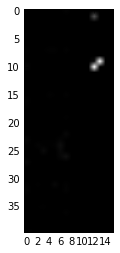

Seen 4000 examples


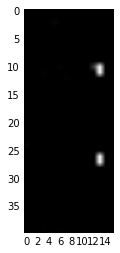

Finished epoch 0. Mean loss = 0.158770.
Augmenting
Training paths length =  4508
Seen 2000 examples


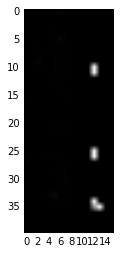

Seen 4000 examples


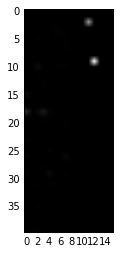

Finished epoch 1. Mean loss = 0.152714.
Augmenting
Training paths length =  4508
Seen 2000 examples


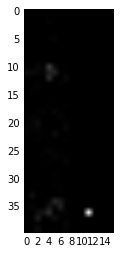

Seen 4000 examples


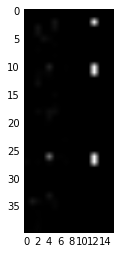

Finished epoch 2. Mean loss = 0.138419.
Augmenting
Training paths length =  4508
Seen 2000 examples


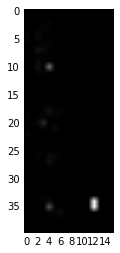

Seen 4000 examples


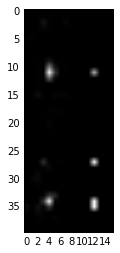

Finished epoch 3. Mean loss = 0.119843.
Augmenting
Training paths length =  4508


In [ ]:
if __name__ == "__main__":

    batchSize = 5
    iterations = 100
    epochs = 10
    testSubset = 100
    lr = 0.01
    
    learning_rate = tf.placeholder(tf.float32,shape=[])
    mse = tf.reduce_mean(tf.reduce_sum(tf.square(yPred - y_),(1,2,3))/batchSize)
    opt = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    opt_operation = opt.minimize(mse)
    
  
    dataGen = dataGenerator(cvSplit = 0.8, batchSize=batchSize,inputDim=inputDim,outputDim=outputDim)
    
    epochs = 10
    
    
    with tf.Session() as sess:
        with tf.variable_scope("deCnn"):
            tf.initialize_all_variables().run()
            
            trainLosses = []
            for epoch in xrange(epochs):
                i = 0
                trainGen = dataGen.gen(train=1)
                testGen = dataGen.gen(train=0)
                trainEpochLosses = []
                finished = 0
                while finished == 0:
                    batchX, batchY, finished = trainGen.next()
                    _,yPred_,loss = sess.run([opt_operation,yPred,mse],feed_dict={x:batchX,y_:batchY,learning_rate:0.01})
                    trainEpochLosses.append(loss)
                    i += 1
                    if i % 400 == 0:
                        print("Seen %d examples" % (i*batchSize))
                        preds = np.vstack(tuple([row for row in yPred_.squeeze()]))
                        truth = np.vstack(tuple([row for row in batchY.squeeze()]))
                        predsTruth = np.hstack((preds,truth))
                        plt.imshow(predsTruth,cmap=cm.gray)
                        plt.show()
                        
                trainEpochLoss = np.array(trainEpochLosses).mean()
                trainLosses.append(trainEpochLoss)
                
                print("Finished epoch %d. Mean loss = %f." % (epoch,trainEpochLoss))
                
    sess.close()
            

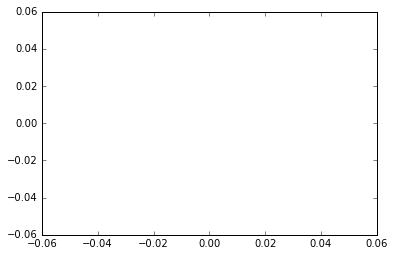

In [232]:
plt.plot(trainLosses)